<a href="https://colab.research.google.com/github/srikarreddy1729/pipeline-for-geospatial/blob/main/landcover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

Segmentation Models: using `keras` framework.


In [2]:
pip install -U segmentation-models

In [32]:
patch_size = 256

In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 79.7 MB/s eta 0:00:00


In [3]:
import rasterio

In [5]:
dataset = rasterio.open('OUTPUT.tif')

In [6]:
dataset.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4618, 'height': 4019, 'count': 1, 'crs': CRS.from_epsg(32750), 'transform': Affine(3.0, 0.0, 281019.0,
       0.0, -3.0, 9091602.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

In [44]:
import rasterio
import numpy as np

# Open the tif image
with rasterio.open("image.tif") as src:

  # Get the width and height of the image
  width = src.width
  height = src.height

  # Calculate the smallest multiple of 256 that is greater than or equal to the width and height of the image
  new_width = int(np.ceil(width / 256.0)) * 256
  new_height = int(np.ceil(height / 256.0)) * 256

print(new_width,new_height)



4864 4096


In [47]:
import rasterio
from rasterio.windows import Window

# Define crop dimensions
crop_width = 4864
crop_height = 4096

# Open the TIFF file
with rasterio.open('image.tif') as src:
    # Calculate crop window
    left = (src.width - crop_width) // 2
    top = (src.height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height
    window = Window(left, top, crop_width, crop_height)

    # Read the cropped data
    cropped_data = src.read(window=window)

    # Create a new cropped TIFF file
    profile = src.profile
    profile.update(width=crop_width, height=crop_height)

    with rasterio.open('output.tif', 'w', **profile) as dst:
        dst.write(cropped_data)


In [51]:


# Open the tif image
with rasterio.open("mask.tif") as src:

  # Get the width and height of the image
  width = src.width
  height = src.height

  # Calculate the smallest multiple of 256 that is greater than or equal to the width and height of the image
  new_width = int(np.ceil(width / 256.0)) * 256
  new_height = int(np.ceil(height / 256.0)) * 256

print(new_width,new_height)



4864 4096


In [52]:
import rasterio
from rasterio.windows import Window

# Define crop dimensions
crop_width = 4864
crop_height = 4096

# Open the TIFF file
with rasterio.open('mask.tif') as src:
    # Calculate crop window
    left = (src.width - crop_width) // 2
    top = (src.height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height
    window = Window(left, top, crop_width, crop_height)

    # Read the cropped data
    cropped_data = src.read(window=window)

    # Create a new cropped TIFF file
    profile = src.profile
    profile.update(width=crop_width, height=crop_height)

    with rasterio.open('crop_mask.tif', 'w', **profile) as dst:
        dst.write(cropped_data)


In [66]:
src = rasterio.open('output.tif')

In [67]:
image = np.array(src.read())

In [70]:
import rasterio
import numpy as np

# Open the TIFF file
with rasterio.open('output.tif') as src:
    # Define patch dimensions
    patch_size = (256, 256)

    # Read the TIFF data
    tiff_data = src.read()

    # Get the shape of the TIFF data
    num_bands, height, width = tiff_data.shape

    # Calculate the number of patches in each dimension
    num_patches_height = height // patch_size[0]
    num_patches_width = width // patch_size[1]

    # Extract and save multiband patch images
    patch_id = 0
    for i in range(num_patches_height):
        for j in range(num_patches_width):
            # Calculate the patch boundaries
            h_start = i * patch_size[0]
            h_end = (i + 1) * patch_size[0]
            w_start = j * patch_size[1]
            w_end = (j + 1) * patch_size[1]

            # Extract the multiband patch
            patch = tiff_data[:, h_start:h_end, w_start:w_end]

            # Create a new TIFF file for the patch
            patch_file = f'patch_{patch_id}.tif'
            with rasterio.open(patch_file, 'w', driver='GTiff', height=patch_size[0], width=patch_size[1],
                               count=num_bands, dtype=patch.dtype) as dst:
                for band in range(num_bands):
                    dst.write(patch[band], band + 1)

            patch_id += 1


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [77]:
!mkdir /content/patched_images

In [78]:
!mv /content/patch_*.tif /content/patched_images

In [79]:
import rasterio
import numpy as np

# Open the TIFF file
with rasterio.open('output.tif') as src:
    # Define patch dimensions
    patch_size = (256, 256)

    # Read the TIFF data
    tiff_data = src.read()

    # Get the shape of the TIFF data
    num_bands, height, width = tiff_data.shape

    # Calculate the number of patches in each dimension
    num_patches_height = height // patch_size[0]
    num_patches_width = width // patch_size[1]

    # Extract and save multiband patch images
    patch_id = 0
    for i in range(num_patches_height):
        for j in range(num_patches_width):
            # Calculate the patch boundaries
            h_start = i * patch_size[0]
            h_end = (i + 1) * patch_size[0]
            w_start = j * patch_size[1]
            w_end = (j + 1) * patch_size[1]

            # Extract the multiband patch
            patch = tiff_data[:, h_start:h_end, w_start:w_end]

            # Create a new TIFF file for the patch
            patch_file = f'patch_{patch_id}.tif'
            with rasterio.open(patch_file, 'w', driver='GTiff', height=patch_size[0], width=patch_size[1],
                               count=num_bands, dtype=patch.dtype) as dst:
                for band in range(num_bands):
                    dst.write(patch[band], band + 1)

            patch_id += 1


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [80]:
import os

# Define the directory where the files are located
directory = '/content/'

# Rename the files
for filename in os.listdir(directory):
    if filename.startswith('patch_') and filename.endswith('.tif'):
        new_filename = 'mask_' + filename
        os.rename(os.path.join(directory, filename), os.path.join(directory, new_filename))


In [81]:
!mkdir /content/masked_images

In [82]:
!mv /content/mask_patch_*.tif /content/masked_images

In [85]:
!mkdir /content/256_patches

In [86]:
!mv /content/masked_images/ /content/patched_images/ /content/256_patches

In [84]:
!pip install split-folders

In [87]:
!mkdir /content/data_for_training_and_testing

In [89]:
input_folder = '/content/256_patches/'
output_folder = '/content/data_for_training_and_testing/'

In [90]:
import splitfolders

In [91]:
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values


Copying files: 608 files [00:08, 75.50 files/s] 


In [92]:
!mkdir /content/data_for_training_and_testing/train_images/ /content/data_for_training_and_testing/train_masks/ /content/data_for_training_and_testing/val_images/ /content/data_for_training_and_testing/val_masks/


In [93]:
!mkdir /content/data_for_training_and_testing/train_images/train /content/data_for_training_and_testing/train_masks/train /content/data_for_training_and_testing/val_images/val /content/data_for_training_and_testing/val_masks/val


In [94]:
mv /content/data_for_training_and_testing/train/patched_images/ /content/data_for_training_and_testing/train_images/train/

In [95]:
!mv /content/data_for_training_and_testing/train/masked_images /content/data_for_training_and_testing/train_masks/train/

In [98]:
!mv /content/data/val/patched_images/ /content/data/val_images/val

In [99]:
!mv /content/data/val/masked_images/ /content/data/val_masks/val

In [101]:
!mv /content/data/train_masks/train/masked_images/* /content/data/train_masks/train

In [102]:
!mv /content/data/val_images/val/patched_images/* /content/data/val_images/val

In [103]:
!mv /content/data/val_masks/val/masked_images/* /content/data/val_masks/val

In [104]:
train_img_dir = "data/train_images/train/"
train_mask_dir = "data/train_masks/train/"

In [107]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
num_masks = len(os.listdir(train_mask_dir))

In [108]:
num_masks

229

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
!mkdir -p "/content/drive/My Drive/exp"

In [122]:
!cp -r /content/data/ /content/drive/MyDrive/exp/


In [123]:
!cp -r /content/256_patches/ /content/drive/MyDrive/exp/

In [125]:
!cp -r /content/output.tif /content/drive/MyDrive/exp/

In [126]:
!cp -r /content/crop_mask.tif /content/drive/MyDrive/exp/

In [132]:
!pip install --upgrade opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


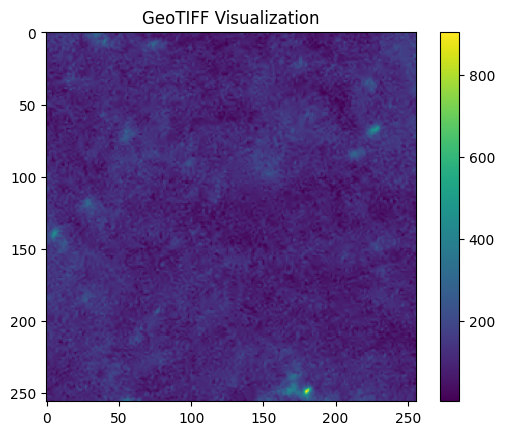

In [7]:
import rasterio
import matplotlib.pyplot as plt

# Open the GeoTIFF file
with rasterio.open('/content/data/train_images/train/patch_104.tif') as src:
    # Read the raster data
    raster_data = src.read()

    # Extract the first band for visualization
    band = raster_data[0]

    # Visualize the band
    plt.imshow(band, cmap='viridis')
    plt.title('GeoTIFF Visualization')
    plt.colorbar()
    plt.show()


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
(array([0.], dtype=float32), array([65536]))


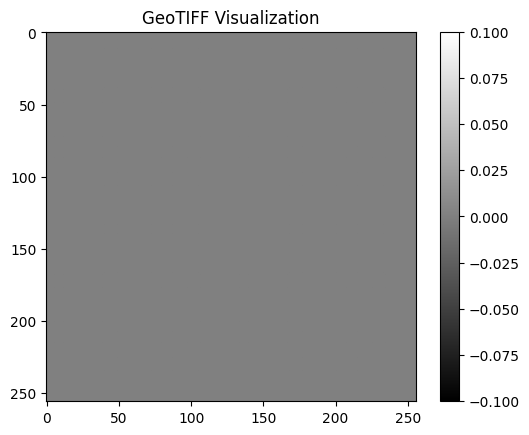

In [16]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Open the GeoTIFF file
with rasterio.open('/content/data/train_masks/train/mask_patch_104.tif') as src:
    # Read the raster data
    raster_data = src.read()
    k = np.array(raster_data)
    print(raster_data)
    print(np.unique(k, return_counts=True))

    # Extract the first band for visualization
    band = raster_data[0]

    # Visualize the band
    plt.imshow(band, cmap='gray')
    plt.title('GeoTIFF Visualization')
    plt.colorbar()
    plt.show()


In [5]:
import rasterio
import numpy as np
import os

# Set the folder path
folder_path = '/content/data/train_masks/train'

# Initialize an empty list to store the arrays
arrays_list = []

# Iterate through the TIFF files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        file_path = os.path.join(folder_path, filename)

        # Open the TIFF file
        with rasterio.open(file_path) as src:
            # Read the raster data as a NumPy array
            array = src.read(1)  # Change the band index if required

            # Add the array to the list
            arrays_list.append(array)

# Print the list of arrays
print(arrays_list)



/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0

In [6]:
labels = np.array(arrays_list)

In [7]:
np.unique(labels, return_counts = True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13.,
        14., 15., 16., 18., 20., 21., 22.], dtype=float32),
 array([14607008,    99320,    10007,     3944,     2987,    12292,
            2552,     3078,      475,     9324,    62120,   111693,
             443,     3856,     3015,     1851,      468,     4096,
             180,     3499]))

In [8]:
labels.shape

(228, 256, 256)

In [9]:
import rasterio
import numpy as np
import os

# Set the folder path
folder_path = '/content/data/train_images/train'

# Initialize an empty list to store the arrays
arrays_list = []

# Iterate through the TIFF files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        file_path = os.path.join(folder_path, filename)

        # Open the TIFF file
        with rasterio.open(file_path) as src:
            # Read all bands of the TIFF file as a NumPy array
            array = src.read()

            # Add the array to the list
            arrays_list.append(array)

# Print the list of arrays
print(arrays_list)


[array([[[ 275.66006 ,  291.5435  ,  230.76518 , ...,   45.750725,
           56.54553 ,   54.982014],
        [ 336.22678 ,  325.11578 ,  263.0021  , ...,   74.883865,
           84.66197 ,   57.354614],
        [ 376.5657  ,  354.46777 ,  275.44366 , ...,  102.2112  ,
          110.843254,   74.34553 ],
        ...,
        [ 172.2809  ,  180.56984 ,  176.50218 , ...,  259.3523  ,
          319.61993 ,  341.93024 ],
        [ 167.96162 ,  200.      ,  186.83015 , ...,  289.41544 ,
          334.81406 ,  348.69058 ],
        [ 157.47304 ,  184.34792 ,  190.96939 , ...,  344.5957  ,
          358.53098 ,  357.92624 ]],

       [[ 391.6374  ,  388.2958  ,  315.20523 , ...,  134.44868 ,
          132.46707 ,  100.443985],
        [ 453.68344 ,  419.56207 ,  325.55777 , ...,  140.3071  ,
          131.39111 ,   89.943794],
        [ 436.99088 ,  402.2339  ,  329.34503 , ...,  140.10385 ,
          134.36209 ,  122.51374 ],
        ...,
        [ 264.62924 ,  279.7849  ,  268.15665 , ..., 

In [10]:
images = np.array(arrays_list)

In [11]:
images.shape

(228, 8, 256, 256)

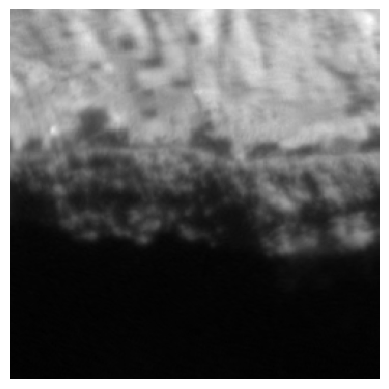

In [34]:
plt.imshow(images[1][7], cmap='gray')
plt.axis('off')
plt.show()

In [50]:
np.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13.,
       14., 15., 16., 18., 20., 21., 22.], dtype=float32)

In [12]:
from tensorflow.keras.utils import to_categorical

# Perform one-hot encoding on the labels
one_hot_labels = to_categorical(labels, num_classes=23)


In [13]:
one_hot_labels.shape

(228, 256, 256, 23)

In [54]:
images.shape[1]

8

In [14]:
import numpy as np

# Normalize each band of the image
normalized_images = np.zeros_like(images, dtype='float32')
for band in range(images.shape[1]):
    band_min = np.min(images[:, band])
    band_max = np.max(images[:, band])
    normalized_images[:, band] = (images[:, band] - band_min) / (band_max - band_min)

In [15]:
np.max(normalized_images)

1.0

In [16]:
reshaped_images = normalized_images.reshape(-1, 256, 256, 8)

In [17]:
reshaped_images.shape

(228, 256, 256, 8)

In [18]:
one_hot_labels.shape

(228, 256, 256, 23)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_images, one_hot_labels, test_size = 0.20, random_state = 42)


In [3]:
# https://youtu.be/jvZm8REF2KY
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=23, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=8):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model


In [2]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


ERROR: Could not find a version that satisfies the requirement simple_multi_unet_model (from versions: none)
ERROR: No matching distribution found for simple_multi_unet_model


In [20]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666,0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


metrics=['accuracy', jacard_coef]


model = multi_unet_model(n_classes=23, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=1,
                    validation_data=(X_test, y_test),
                    shuffle=False)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  1168        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [21]:
model.save('landcover_model.hdf5')

In [ ]:
# https://youtu.be/0W6MKZqSke8
"""
Author: Dr. Sreenivas Bhattiprolu

Prediction using smooth tiling as descibed here...

https://github.com/Vooban/Smoothly-Blend-Image-Patches


"""

import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm




from keras.models import load_model
model = load_model("landcover_model.hdf5", compile=False)

# size of patches
patch_size = 256

# Number of classes
n_classes = 23


###################################################################################
#Predict using smooth blending

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


final_prediction = np.argmax(predictions_smooth, axis=2)

#Save prediction and original mask for comparison
plt.imsave('data/test_images/N-34-66-C-c-4-3.tif_segmented.jpg', final_prediction)
plt.imsave('data/test_images/N-34-66-C-c-4-3.tif_mask.jpg', original_mask)
###################


plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.show()

#############################

In [2]:
import rasterio
import numpy as np

In [3]:
with rasterio.open('output.tif') as src:
            # Read all bands of the TIFF file as a NumPy array
    new_array = src.read()

img = np.array(new_array)

import numpy as np

# Normalize each band of the image
normalized_image = np.zeros_like(img, dtype='float32')
for band in range(img.shape[1]):
    band_min = np.min(img[:, band])
    band_max = np.max(img[:, band])
    normalized_image[:, band] = (img[:, band] - band_min) / (band_max - band_min)


In [29]:
reshaped_image = normalized_image.reshape(-1,4096, 4864, 8)

In [30]:
reshaped_image.shape

(1, 4096, 4864, 8)

In [4]:
from keras.models import load_model
model = load_model("landcover_model.hdf5", compile=False)

# size of patches
patch_size = 256

# Number of classes
n_classes = 23

In [5]:
# https://youtu.be/0W6MKZqSke8

"""
Author: Dr. Sreenivas Bhattiprolu

Original code is from the following source. It comes with MIT License so please mention
the original reference when sharing.

The original code has been modified to fix a couple of bugs and chunks of code
unnecessary for smooth tiling are removed.

# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE

"""
"""Perform smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = True
    # See end of file for the rest of the __main__.
else:
    PLOT_PROGRESS = False


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.
    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )
    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):            #SREENI: Changed padx to pady (Bug in original code)
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.
    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd



In [41]:
model.input

<KerasTensor: shape=(None, 256, 256, 8) dtype=float32 (created by layer 'input_1')>

In [1]:
predictions_smooth = predict_img_with_smooth_windowing(
    normalized_image,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=23,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


final_prediction = np.argmax(predictions_smooth, axis=2)

NameError: ignored